In [39]:
#lib import
import numpy as np
import pandas as pd
import pydicom # read *.dcm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import os
import matplotlib.pyplot as plt
import nibabel as nib

# ROOT = '../input/rsna-2022-cervical-spine-fracture-detection'
ROOT = 'D:\Code\RSNA\RSNA_data'

In [41]:
# File Read
filenames = os.listdir(ROOT)

# define dir
train_dir = os.path.join(ROOT, 'train.csv')
test_dir = os.path.join(ROOT, 'test.csv')
bbox_dir = os.path.join(ROOT, 'train_bounding_boxes.csv')
sap_subm_dir = os.path.join(ROOT, 'sample_submission.csv')
train_images_dir = os.path.join(ROOT, 'train_images')
test_images_dir = os.path.join(ROOT, 'test_images')
seg_dir = os.path.join(ROOT, 'segmentations')

# read csv
train = pd.read_csv(train_dir)
test = pd.read_csv(test_dir)
bbox_df = pd.read_csv(bbox_dir)
sap_subm = pd.read_csv(sap_subm_dir)

# get train & test filenames
train_images = os.listdir(train_images_dir)
test_images = os.listdir(test_images_dir)

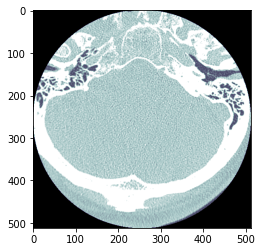

In [46]:
# check img
index = 6
foldername = train_images[index]

filename = os.listdir(os.path.join(train_images_dir, foldername))[0]
ds = pydicom.dcmread(os.path.join(train_images_dir, foldername,filename))
img = apply_voi_lut(ds.pixel_array,ds)
plt.imshow(img, cmap="bone")
plt.show()


1.2.826.0.1.3680043.1363
           StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7
4  1.2.826.0.1.3680043.1363                1   0   0   0   0   1   0   0
             StudyInstanceUID          x          y     width    height  \
989  1.2.826.0.1.3680043.1363  244.06703  337.04285  30.51028  29.55679   
990  1.2.826.0.1.3680043.1363  244.00000  335.00000  30.00000  32.00000   
991  1.2.826.0.1.3680043.1363  245.00000  332.00000  30.00000  35.00000   
992  1.2.826.0.1.3680043.1363  245.02047  329.41526  29.55680  37.66111   
993  1.2.826.0.1.3680043.1363  245.00000  328.00000  27.00000  33.00000   
994  1.2.826.0.1.3680043.1363  246.00000  328.00000  24.00000  29.00000   
995  1.2.826.0.1.3680043.1363  246.45065  326.55493  21.92923  24.78958   

     slice_number  
989            85  
990            86  
991            87  
992            88  
993            89  
994            90  
995            91  
(199, 512, 512)
[[['1.2.826.0.1.3680043.1363']]

 [[244.06703]]

 [[

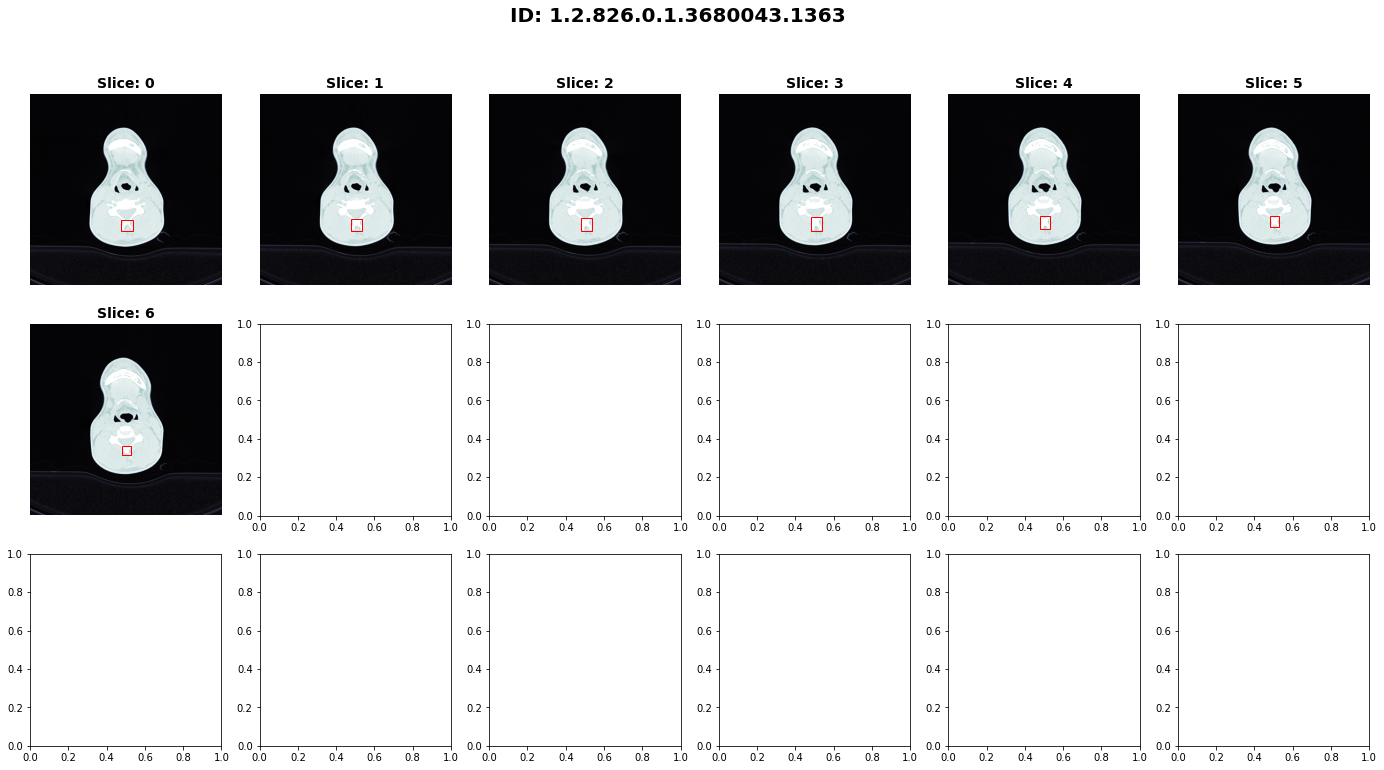

In [72]:
# draw seg and bbox
index = 7
# foldername = train_images[index]

# find have seg file
seg_file = os.listdir(seg_dir)
foldername_list = seg_file[index].split('.')[:len(seg_file[index].split('.'))-1]
foldername = ''
for index, i in enumerate(foldername_list):
    foldername += i
    if index != len(foldername_list) - 1:
        foldername += '.'
print(foldername)
# check file data
fractured_info = train[train['StudyInstanceUID']==foldername]
print(fractured_info)
bbox_info = bbox_df[bbox_df['StudyInstanceUID']==foldername]
print(bbox_info)

img_with_bbox_index = np.asarray(bbox_info['slice_number'])
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {foldername}', weight="bold", size=20)

# read segmentations
nii_example = nib.load(os.path.join(ROOT, seg_dir, foldername+'.nii'))
seg = nii_example.get_fdata()
seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)
print(seg.shape)
for i, index in enumerate(img_with_bbox_index):
    file = os.path.join(train_images_dir, foldername,f"{index}.dcm")
    ds = pydicom.dcmread(file)
    img = apply_voi_lut(ds.pixel_array,ds)

    # draw bbox
    bbox = np.asarray([bbox_info[bbox_info['slice_number']==index]]).T
    print(bbox)
    rect = plt.Rectangle((bbox[1], bbox[2]), bbox[3], bbox[4], fill=False, edgecolor = 'red',linewidth=1)
    
    # draw segamentation
    # seg_index = seg[index]
    # img [np.where(seg_index != 0)] = 0

    # Plot the image
    x = i // 6
    y = i % 6

    slice_no = i
    axes[x, y].add_patch(rect)
    axes[x, y].imshow(img, cmap="bone")
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')
